# Plip dataset

We inspect the plip dataset which will later be used to find protein-ligand interactions. For each protein-ligand complex we will extract a single peptidic chain with a ligand (in case there are multiple), we'll fix the ligand bond orders and save both the protein and ligand to new files.

With the data we obtain from this notebook we'll then be ready to compute protein-ligand interactions and compare with plip's paper:

- Salentin,S. et al. PLIP: fully automated protein-ligand interaction profiler. Nucl. Acids Res. (1 July 2015) 43 (W1): W443-W447. doi: 10.1093/nar/gkv315

In [1]:
import pl_interactions as pli
import mdtraj as mdt
import nglview as nv
import numpy as np
from rdkit.Chem import AllChem as Chem

from copy import deepcopy
from collections import defaultdict
import os
from pprint import pprint

## Load the files

In [2]:
data_dir = "../../datasets/ligand-receptor/test_cases/plip"
os.path.isdir(data_dir)

True

In [3]:
pdbs = []
smi_files = []
pdb_ligands = defaultdict(list)

for root, _, filenames in os.walk(data_dir):
    for file in filenames:
        pdb_name = root.split("/")[-1]
        if file.endswith(".pdb"):
            if len(file.split("_")) == 1:
                pdbs.append(file)
            else:
                pdb_ligands[pdb_name].append(file)
            
        elif file.endswith(".smi"):
            smi_files.append(os.path.join(root, file))

In [ ]:
pdbs

['2REG.pdb', '3BBH.pdb', '4MWW.pdb', '1M7W.pdb', '1XDN.pdb']

In [5]:
smi_files

['../../datasets/ligand-receptor/test_cases/plip/2REG/ligands.smi',
 '../../datasets/ligand-receptor/test_cases/plip/3BBH/ligands.smi',
 '../../datasets/ligand-receptor/test_cases/plip/4MWW/ligands.smi',
 '../../datasets/ligand-receptor/test_cases/plip/1M7W/ligands.smi',
 '../../datasets/ligand-receptor/test_cases/plip/1XDN/ligands.smi']

In [6]:
pdb_ligands

defaultdict(list,
            {'2REG': ['CHT_D_chain.pdb', 'CHT_C_chain.pdb'],
             '3BBH': ['GOL_C_chain.pdb',
              'GOL_F_chain.pdb',
              'GOL_D_chain.pdb',
              'SFG_D_chain.pdb',
              'SFG_C_chain.pdb'],
             '4MWW': ['BMA_B_chain.pdb',
              'NAG_B_chain.pdb',
              'NAG_C_chain.pdb',
              'MAN_B_chain.pdb',
              'G39_C_chain.pdb'],
             '1M7W': ['DAO_F_chain.pdb',
              'DAO_H_chain.pdb',
              'DAO_E_chain.pdb',
              'DAO_G_chain.pdb'],
             '1XDN': ['ATP_B_chain.pdb']})

## HNF4 alpha ligand binding domain (Hhydrophobic interactions).

HNF4 alpha ligand binding domain and lauric acid. PDB id is 1M7W

### Extract a chain

In [7]:
def print_traf_info(traj):
    
    print(f"Num atoms: {traj.n_atoms}")
    print(f"Num chains: {traj.n_chains}")
    print(f"Num residues: {traj.n_residues}")
    

def full_file_path(file_name):
    name = file_name.split(".")[0] + "/" + file_name
    return os.path.join(data_dir, name)

In [8]:
index = 3
pdb_id = "1M7W"
traj_1m7w = mdt.load(full_file_path(pdbs[index]))
print_traf_info(traj_1m7w)

Num atoms: 7176
Num chains: 12
Num residues: 960


In [9]:
nv.show_mdtraj(traj_1m7w)

NGLWidget()

In [10]:
df, _ = traj_1m7w.topology.to_dataframe()

In [11]:
df[df["chainID"] == 4]

,serial,name,element,resSeq,resName,chainID,segmentID
7046,7051,O1,O,700,DAO,4,
7047,7052,O2,O,700,DAO,4,
7048,7053,C1,C,700,DAO,4,
7049,7054,C2,C,700,DAO,4,
7050,7055,C3,C,700,DAO,4,
7051,7056,C4,C,700,DAO,4,
7052,7057,C5,C,700,DAO,4,
7053,7058,C6,C,700,DAO,4,
7054,7059,C7,C,700,DAO,4,
7055,7060,C8,C,700,DAO,4,


In [12]:
# Extract a single chain with a ligand
chains = [0, 4]
traj_1m7w_A = traj_1m7w.atom_slice(
        [atom.index for atom in traj_1m7w.topology.atoms if (atom.residue.chain.index in chains)]
    )
print_traf_info(traj_1m7w_A)

Num atoms: 1791
Num chains: 2
Num residues: 224


In [13]:
nv.show_mdtraj(traj_1m7w_A)

NGLWidget()

### Inspect the ligand

Inspection of the ligand from the pdb file reveals that bond orders are incorrect. We proceed to fix that.

In [14]:
def remove_conformers(molecule):
    """ Returns a molecule with 0 conformers. """
    mol = deepcopy(molecule)
    mol.RemoveAllConformers()
    return mol

In [15]:
print(pdb_ligands[pdb_id])

['DAO_F_chain.pdb', 'DAO_H_chain.pdb', 'DAO_E_chain.pdb', 'DAO_G_chain.pdb']


DAO number of atoms pdb ligand: 14


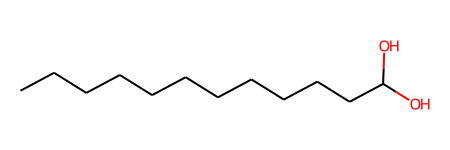

In [16]:
dao_pdb = Chem.MolFromPDBFile(os.path.join(data_dir, pdb_id, pdb_ligands[pdb_id][0]))
print(f"DAO number of atoms pdb ligand: {dao_pdb.GetNumAtoms()}")
remove_conformers(dao_pdb)  # Remove conformers for pretty drawing

In [17]:
supplier = Chem.SmilesMolSupplier(smi_files[index], titleLine=False)
ligands = [mol for mol in supplier if mol is not None]
ligands

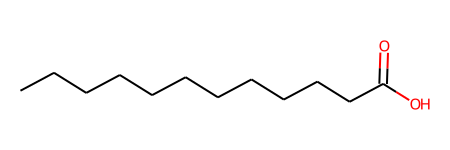

In [18]:
dao_smi = ligands[0]
dao_smi

[11:42:45] WARNING: More than one matching pattern found - picking one



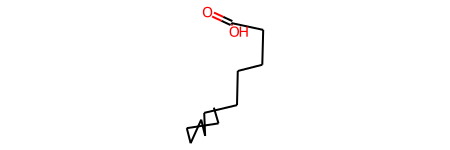

In [19]:
# Fixed mol
dao = Chem.AssignBondOrdersFromTemplate(dao_smi, dao_pdb)
dao

In [20]:
def mol_to_sdf(file_path, mol):
    writer = Chem.SDWriter(file_path)
    writer.write(mol, confId=0)

In [21]:
# Save fixed ligand and chain
mol_to_sdf("./data/1m7w/dao.sdf", dao)
traj_1m7w_A.save_pdb("./data/1m7w/1m7w_A_chain.pdb")

## M. jannaschii Nep1 and Sinefungin (hydrogen bonding)

PDB id is 3BBH

In [22]:
index = 1
pdb_id = "3BBH"
traj_3bbh = mdt.load(full_file_path(pdbs[index]))
print_traf_info(traj_3bbh)

Num atoms: 3655
Num chains: 6
Num residues: 609


In [23]:
nv.show_mdtraj(traj_3bbh)

NGLWidget()

In [24]:
pli.find_ligands_in_traj(traj_3bbh)

['SFG:C', 'GOL:C', 'SFG:D', 'GOL:D', 'GOL:F']

In [25]:
df, _ = traj_3bbh.topology.to_dataframe()

In [26]:
# Chain 3 contains two ligands SFG and GOL. We are only interested in SFG
df[df["chainID"] == 2].head(10)

,serial,name,element,resSeq,resName,chainID,segmentID
3372,3375,N,N,206,SFG,2,
3373,3376,CA,C,206,SFG,2,
3374,3377,C,C,206,SFG,2,
3375,3378,O,O,206,SFG,2,
3376,3379,OXT,O,206,SFG,2,
3377,3380,CB,C,206,SFG,2,
3378,3381,CG,C,206,SFG,2,
3379,3382,CD,C,206,SFG,2,
3380,3383,NE,N,206,SFG,2,
3381,3384,C5',C,206,SFG,2,


In [27]:
# Extract chain with protein and single ligand
chains = [0, 2]

atom_indices = []
for atom in traj_3bbh.topology.atoms:
    if atom.residue.chain.index == chains[0]:
        atom_indices.append(atom.index)
    elif atom.residue.chain.index == chains[1] and atom.residue.name == "SFG":
        atom_indices.append(atom.index)
    
traj_3bbh_A = traj_3bbh.atom_slice(atom_indices)
print_traf_info(traj_3bbh_A)

Num atoms: 1713
Num chains: 2
Num residues: 205


In [28]:
traj_ligand = mdt.load(os.path.join(data_dir, pdb_id, pdb_ligands[pdb_id][-1]))
nv.show_mdtraj(traj_ligand)

NGLWidget()

In [29]:
view = nv.show_mdtraj(traj_3bbh_A)
view.add_component(traj_ligand)
view

NGLWidget()

Why does the ligand look like a stick?

### Inspect ligand

In [30]:
print(pdb_ligands[pdb_id])

['GOL_C_chain.pdb', 'GOL_F_chain.pdb', 'GOL_D_chain.pdb', 'SFG_D_chain.pdb', 'SFG_C_chain.pdb']


SFG number of atoms pdb ligand: 27


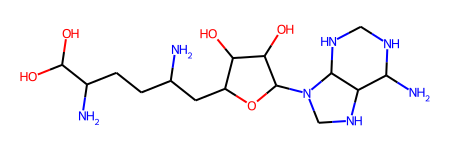

In [31]:
sfg_pdb = Chem.MolFromPDBFile(os.path.join(data_dir, pdb_id, pdb_ligands[pdb_id][-1]))
print(f"SFG number of atoms pdb ligand: {sfg_pdb.GetNumAtoms()}")
remove_conformers(sfg_pdb)  # Remove conformers for pretty drawing

In [32]:
supplier = Chem.SmilesMolSupplier(smi_files[index], titleLine=False)
ligands = [mol for mol in supplier if mol is not None]
ligands

SFG number of atoms smi ligand: 27


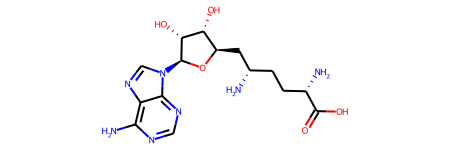

In [33]:
sfg_smi = ligands[0]
print(f"SFG number of atoms smi ligand: {sfg_smi.GetNumAtoms()}")
sfg_smi

[11:42:45] WARNING: More than one matching pattern found - picking one



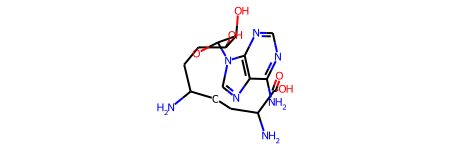

In [34]:
# fixed ligand
sfg = Chem.AssignBondOrdersFromTemplate(sfg_smi, sfg_pdb)
sfg

In [35]:
# Save fixed ligand and extracted chain
mol_to_sdf("./data/3bbh/sfg.sdf", sfg)
traj_3bbh_A.save_pdb("./data/3bbh/3bbh_A_chain.pdb")

## Trypanosoma brucei RNA editing ligase 1 and ATP (aromatic stacking)

Pdb id is 1XDN

In [36]:
index = -1
pdb_id = "1XDN"
traj_1xdn = mdt.load(full_file_path(pdbs[index]))
print_traf_info(traj_1xdn)

Num atoms: 2591
Num chains: 2
Num residues: 707


In [37]:
nv.show_mdtraj(traj_1xdn)

NGLWidget()

In [38]:
pli.find_ligands_in_traj(traj_1xdn)

['ATP:B']

### Inspect ligand

In [39]:
print(pdb_ligands[pdb_id])

['ATP_B_chain.pdb']


ATP number of atoms pdb ligand: 31


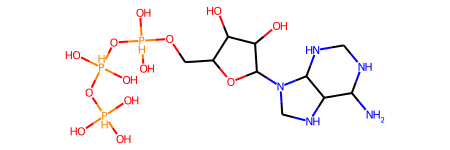

In [40]:
atp_pdb = Chem.MolFromPDBFile(os.path.join(data_dir, pdb_id, pdb_ligands[pdb_id][0]))
print(f"ATP number of atoms pdb ligand: {atp_pdb.GetNumAtoms()}")
remove_conformers(atp_pdb)  # Remove conformers for pretty drawing

In [41]:
supplier = Chem.SmilesMolSupplier(smi_files[index], titleLine=False)
ligands = [mol for mol in supplier if mol is not None]
ligands

ATP number of atoms smi ligand: 31


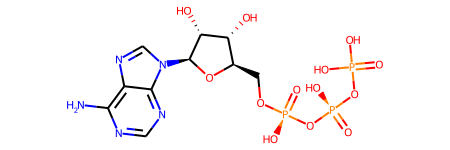

In [42]:
atp_smi = ligands[1]
print(f"ATP number of atoms smi ligand: {atp_smi.GetNumAtoms()}")
atp_smi

[11:42:45] WARNING: More than one matching pattern found - picking one



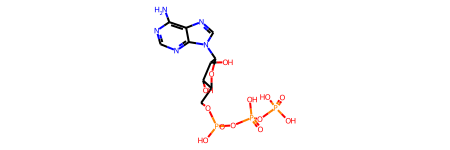

In [43]:
# fixed ligand
atp = Chem.AssignBondOrdersFromTemplate(atp_smi, atp_pdb)
atp

In [44]:
# Save fixed ligand and extracted chain
mol_to_sdf("./data/1xdn/atp.sdf", atp)
traj_1xdn.save_pdb("./data/1xdn/1xdn.pdb")

## ABC-transporter choline binding protein and choline (pi-cation interactions)
Pdb id is 2REG

In [45]:
index = 0
pdb_id = "2REG"
traj_2reg = mdt.load(full_file_path(pdbs[index]))
print_traf_info(traj_2reg)

Num atoms: 4667
Num chains: 6
Num residues: 850


In [46]:
pli.find_ligands_in_traj(traj_2reg)

['CHT:C', 'CHT:D']

In [47]:
nv.show_mdtraj(traj_2reg)

NGLWidget()

In [48]:
# Extract a single chain with a ligand
chains = [0, 2]
traj_2reg_A = traj_2reg.atom_slice(
        [atom.index for atom in traj_2reg.topology.atoms if (atom.residue.chain.index in chains)]
    )
print_traf_info(traj_2reg_A)

Num atoms: 2203
Num chains: 2
Num residues: 291


In [49]:
nv.show_mdtraj(traj_2reg_A)

NGLWidget()

### Inspect ligands

In [50]:
print(pdb_ligands[pdb_id])

['CHT_D_chain.pdb', 'CHT_C_chain.pdb']


CHT number of atoms pdb ligand: 7


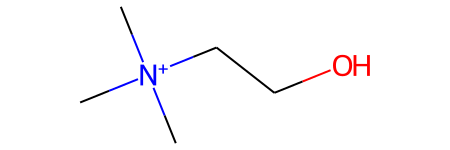

In [51]:
cht_pdb = Chem.MolFromPDBFile(os.path.join(data_dir, pdb_id, pdb_ligands[pdb_id][-1]))
print(f"CHT number of atoms pdb ligand: {cht_pdb.GetNumAtoms()}")
remove_conformers(cht_pdb)  # Remove conformers for pretty drawing

In [52]:
supplier = Chem.SmilesMolSupplier(smi_files[index], titleLine=False)
ligands = [mol for mol in supplier if mol is not None]
ligands

CHT number of atoms smi ligand: 7


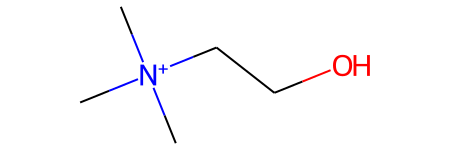

In [53]:
cht_smi = ligands[0]
print(f"CHT number of atoms smi ligand: {cht_pdb.GetNumAtoms()}")
cht_smi

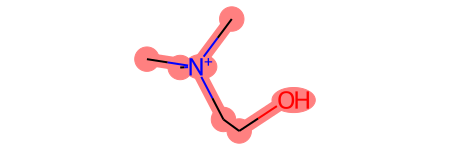

In [54]:
# This one doesn't need fixing but still...
cht = Chem.AssignBondOrdersFromTemplate(cht_smi, cht_pdb)
cht

In [55]:
# Save fixed ligand and extracted chain
mol_to_sdf("./data/2reg/cht.sdf", cht)
traj_2reg_A.save_pdb("./data/2reg/2reg.pdb")

## Shanghai N9 neuraminidase and oseltamivir carboxylate (salt bridges)

PDB id is 4MWW

In [56]:
index = 2
pdb_id = "4MWW"
traj_4mmw = mdt.load(full_file_path(pdbs[index]))
print_traf_info(traj_4mmw)

Num atoms: 3698
Num chains: 3
Num residues: 892


In [57]:
pli.find_ligands_in_traj(traj_4mmw)

['NAG:B', 'BMA:B', 'MAN:B', 'NAG:C', 'G39:C']

In [58]:
nv.show_mdtraj(traj_4mmw)

NGLWidget()

In [59]:
# Extract the protein with the G39 ligand
atom_indices = []

for atom in traj_4mmw.topology.atoms:
    if atom.residue.chain.index == 0 or \
        atom.residue.name == "G39":
        atom_indices.append(atom.index)

traj_4mmw = traj_4mmw.atom_slice(atom_indices)
print_traf_info(traj_4mmw)

Num atoms: 3073
Num chains: 2
Num residues: 389


In [60]:
nv.show_mdtraj(traj_4mmw)

NGLWidget()

### Inspect the ligandprint(pdb_ligands[pdb_id])

In [61]:
print(pdb_ligands[pdb_id])

['BMA_B_chain.pdb', 'NAG_B_chain.pdb', 'NAG_C_chain.pdb', 'MAN_B_chain.pdb', 'G39_C_chain.pdb']


G39 number of atoms pdb ligand: 20


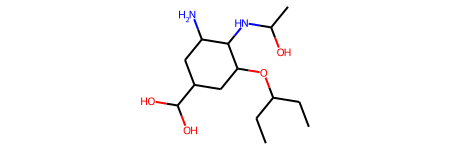

In [62]:
g39_pdb = Chem.MolFromPDBFile(os.path.join(data_dir, pdb_id, pdb_ligands[pdb_id][-1]))
print(f"G39 number of atoms pdb ligand: {g39_pdb.GetNumAtoms()}")
remove_conformers(g39_pdb)  # Remove conformers for pretty drawing

In [63]:
supplier = Chem.SmilesMolSupplier(smi_files[index], titleLine=False)
ligands = [mol for mol in supplier if mol is not None]
ligands

G39 number of atoms smi ligand: 20


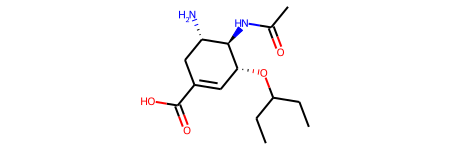

In [64]:
g39_smi = ligands[-1]
print(f"G39 number of atoms smi ligand: {g39_smi.GetNumAtoms()}")
remove_conformers(g39_smi)  # Remove conformers for pretty drawing

[11:42:46] WARNING: More than one matching pattern found - picking one



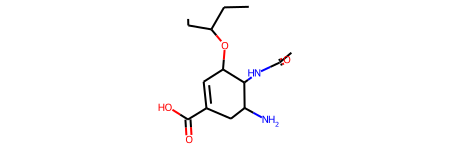

In [65]:
# Fixed_ligand
g39 = Chem.AssignBondOrdersFromTemplate(g39_smi, g39_pdb)
g39

In [66]:
# Save fixed ligand and extracted chain
mol_to_sdf("./data/4mww/g39.sdf", g39)
traj_2reg_A.save_pdb("./data/4mww/4mww.pdb")